# The Capital Asset Pricing Model, Fama-French three-factor model and  Arbitrage Pricing Theory


The Capital Asset Pricing Model (CAPM) is a classic measure of the cost of capital. It is used often in finance to evaluate the price of assets and to assess the impact of the risk premium from the market at large. 



Reference:[Lecture 30](https://www.quantopian.com/lectures/the-capital-asset-pricing-model-and-arbitrage-pricing-theory)

# The Capital Asset Pricing Model
We can express the CAPM more clearly like so:

$$E[R_i] = R_F + \beta(E[R_M] - R_F)$$

where $R_i$ is the return of asset $i$, $R_F$ is the risk-free rate, and $R_M$ is the return of the market. The CAPM is one of the most basic measures of the cost of capital. It determines the minimum return required to entice investors to hold a certain asset.

In this article, we take the return of holding Bills as risk-free rate.

## Testing CAPM

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt

In [20]:
start_date = '2014-01-01'
end_date = '2014-12-31'

# choose stock
R = get_pricing('AAPL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

# risk-free proxy
R_F = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

# find it's beta against market
M = get_pricing('SPY', start_date=start_date, end_date=end_date, fields='price').pct_change()[1:]

AAPL_results = regression.linear_model.OLS(R-R_F, sm.add_constant(M)).fit()
AAPL_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     59.35
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           3.12e-13
Time:                        08:53:46   Log-Likelihood:                 749.29
No. Observations:                 251   AIC:                            -1495.
Df Residuals:                     249   BIC:                            -1488.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                  0.0010      0.001      1.331      0.185        -0.000     0.003
Equity(8554 [SPY])     0.8438      0.110      7.704      0.000         0.628     1.059
==============================================================================
Omnibus:                       74.662   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2468.684
Skew:                          -0.320   Prob(JB):                         0.00
Kurtosis:                      18.351   Cond. No.                         141.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based the preceding results, the beta for APPLE is 0.84377 and the P value is almost zero.

Then, we can then use our calculated beta exposure to make predictions of returns.

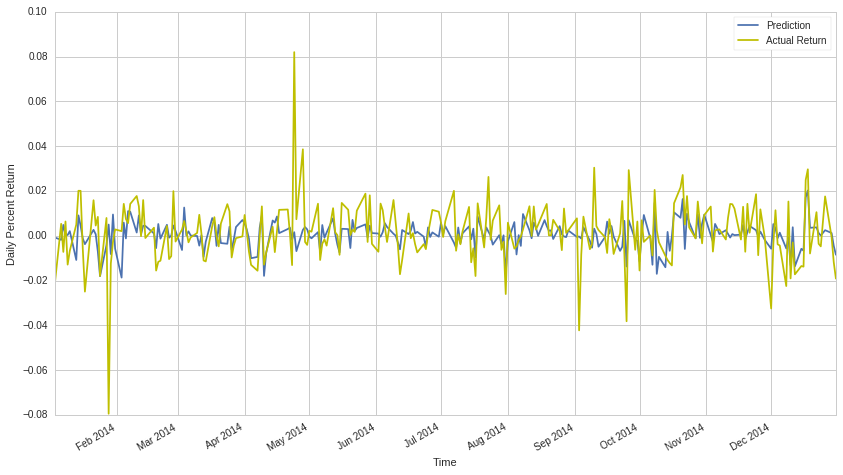

In [11]:
AAPL_beta = AAPL_results.params[1]
predictions = R_F + AAPL_beta*(M - R_F) # CAPM equation

predictions.plot()
R.plot(color='Y')
plt.legend(['Prediction', 'Actual Return'])

plt.xlabel('Time')
plt.ylabel('Daily Percent Return');

### Using CAPM to build a strategy

You can copy the following code into 'Research' -&gt; 'Algorithm', can run a backtest.

The main idea of the following strategy is determining the weights of stocks corresponding to their expected return, and change the portfolio every month.

In [ ]:
from quantopian.pipeline.factors import SimpleBeta, Returns
from quantopian.algorithm import attach_pipeline
from quantopian.algorithm import pipeline_output
from quantopian.algorithm import order_optimal_portfolio
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.filters import Q500US
import quantopian.optimize as opt
from quantopian.pipeline import Pipeline

def initialize(context):
    context.max_leverage = 1.0
    # Attach data pipelines
    attach_pipeline(
        returns_pipeline(),
        'returns'
    )
    attach_pipeline(
        beta_pipeline(),
        'beta'
    )
#Run trading program daily, one hour after market open. 
    schedule_function(balance, 
                      date_rules.month_start(days_offset=0),
                      time_rules.market_open())

def before_trading_start(context, data):
    returns_data = pipeline_output('returns')['value']
    beta_data = pipeline_output('beta')['value']
    rf = returns_data[symbol('BIL')]
    rm = returns_data[symbol('SPY')]
    context.capm = rf + beta_data*(rm - rf)

beta_length = 30
return_length = 30
# Pipeline definition
def beta_pipeline():
    beta = SimpleBeta(target=symbol('spy'), regression_length=30)
    # universe = QTradableStocksUS()
    spy = Q500US()
    return Pipeline(
        columns={'value': beta,},
        screen = (beta.notnull() & spy)
    )

def returns_pipeline():
    returns = Returns(window_length=30)
    
    return Pipeline(
        columns={'value': returns,},
        screen = (returns.notnull())
    )

def balance(context, data):
    # change the range of capm from [min, max] to [0, max - min], so there is no negative value. 
    target = context.capm - min(context.capm)
    weight = target / sum(target)
    objective = opt.TargetWeights(
      weight
    )
    # Constrain target portfolio's leverage
    max_leverage = opt.MaxGrossExposure(context.max_leverage)

    # Rebalance portfolio using objective
    # and list of constraints
    order_optimal_portfolio(
        objective=objective,
        constraints=[
            max_leverage
        ]
    )

100% Time: 0:00:28|###########################################################|


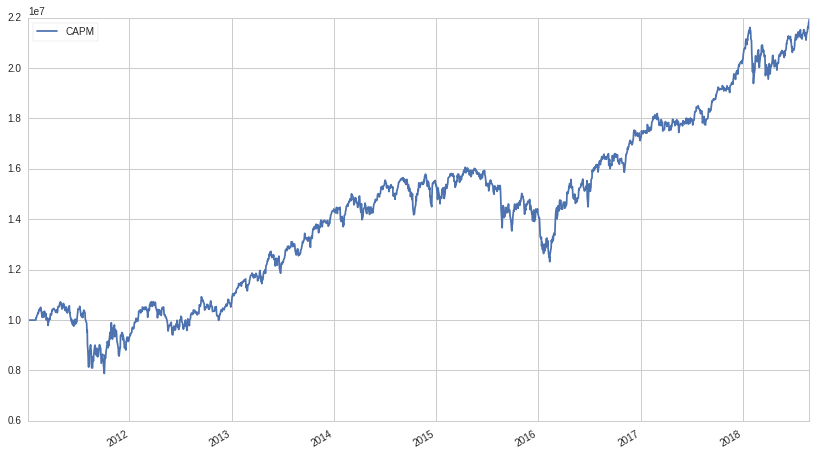

In [27]:
# This code is used to show the result of above algorithm
# For plotting backtest result on Notebooks, you have to backtest your algorithm before, 
# and use corresponding id to plot the result
import matplotlib.pyplot as plt
backtests = get_backtest('5b87af13e22a1744117e67d6')
backtests.cumulative_performance.ending_portfolio_value.plot(label='CAPM')
plt.legend(loc='best')

Although the performance of our algorithm seems good, it doesn't outperform the benchmark.

For more detail on the algorithm, Please refer [CAPM_SPY](https://www.quantopian.com/posts/capm-spy)

For more details on the CAPM, check out the [wikipedia page](https://en.wikipedia.org/wiki/Capital_asset_pricing_model).

# Fama-French three-factor model

The Fama- French three-factor model could be viewed as a natural extension of CAPM, see here:
    $$R_i = R*F + \beta*{M}(R_{M}-R*F) + \beta*{SMB}*SMB + \beta_{HML}*HML$$

The definitions of $R_i$, $R_F$, and $R_M$ remain the same as CAPM. $SMB$ is the portfolio returns of small stocks minus the portfolio returns of big stocks; $HML$ is the portfolio returns for high book-to-market value minus returns of low book-to-market value stocks.

**Small Minus Big (SMB)** is the average return on the three small portfolios minus the average return on the three big portfolios. Based on the size, measured by the market capitalization (numbers of shares outstanding times the end of year price), they classify all stocks into two categories, **S** (small) and **B** (big). Similarly, based on the ratio of book value of equity to the market value of equity, all stocks are classified into three groups of **H** (High), **M** (Median), and **L** (Low). Eventually, we could have the following six groups: **SH, SM, SL, BH, BM, BL**
$$SMB = \frac{1}{3}(SH + SM + SL) - \frac{1}{3}(BH + BM + BL)$$
$$HML = \frac{1}{2}(SH + BH) - \frac{1}{2}(SL + BL)$$

## Testing Fama-French three-factor model

In [57]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.factors import Returns, Latest
from quantopian.pipeline.filters import Q1500US
from quantopian.research import run_pipeline
from quantopian.pipeline.classifiers.fundamentals import Sector
from quantopian.pipeline import CustomFactor
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
import statsmodels.api as sm
import itertools
import pandas as pd
import numpy as np

In [58]:
class MarketEquity(CustomFactor):
    """
    this factor outputs the market cap of every security on the day.
    """
    inputs = [morningstar.valuation.market_cap]
    def compute(self,today,assets,out,mcap):
        out[:] = mcap[0]

class BookEquity(CustomFactor):
    """
    this factor outputs the book value of every security on the day.
    """
    inputs = [morningstar.balance_sheet.tangible_book_value]
    def compute(self,today,assets,out,book):
        out[:] = book[0]

In [59]:
# defining the data we want to get
def get_pipe():
    """
    use our factors to add our pipes and screens.
    """
    # The windows length of calculate returns
    WindowLength = 2
    pipe = Pipeline()  
    
    mkt_cap = MarketEquity(window_length = WindowLength)
    pipe.add(mkt_cap,'market_cap')
    
    book_equity = BookEquity(window_length = WindowLength)
    # book equity over market equity
    be_me = book_equity/mkt_cap
    pipe.add(be_me,'be_me')

    returns = Returns(window_length=WindowLength)
    pipe.add(returns,'returns')
    
    # We focus on the stocks in the Q1500
    sectors = Sector()
    pipe.set_screen(
        (Q1500US())
    )
    
    # defining the small and big
    mkt_cap_rank = mkt_cap.rank()
    small_cap = mkt_cap_rank.percentile_between(0, 50)
    big_cap = mkt_cap_rank.percentile_between(50, 100)
    
    # define the high, median and low
    be_me_rank = be_me.rank()
    little_be = be_me_rank.percentile_between(0, 33)
    mid_be = be_me_rank.percentile_between(33, 67)
    high_be = be_me_rank.percentile_between(67, 100)
    
    pipe.add(small_cap, 'small_cap')
    pipe.add(big_cap, 'big_cap')
    pipe.add(little_be, 'little_be')
    pipe.add(mid_be, 'mid_be')
    pipe.add(high_be, 'high_be')
    
    return pipe

In [66]:
# getting data from pipeline
start_time = pd.Timestamp('20140101')
end_time = pd.Timestamp('20150101')
pipe=get_pipe()
results = run_pipeline(pipe, start_time, end_time)

In [67]:
# calculating SH, SM, SL, BH, BM, BL
sh_data = results[results.small_cap & results.high_be]['returns'].groupby(level=0).mean()
sm_data = results[results.small_cap & results.mid_be]['returns'].groupby(level=0).mean()
sl_data = results[results.small_cap & results.little_be]['returns'].groupby(level=0).mean()
bh_data = results[results.big_cap & results.high_be]['returns'].groupby(level=0).mean()
bm_data = results[results.big_cap & results.mid_be]['returns'].groupby(level=0).mean()
bl_data = results[results.big_cap & results.little_be]['returns'].groupby(level=0).mean()

# calculating SMB, HML, R_M
smb = (sh_data + sm_data + sl_data) / 3. - (bh_data + bm_data + bl_data) / 3.
hml = (sh_data + bh_data) / 2. - (sl_data + bl_data)/ 2.
market_return = results['returns'].groupby(level=0).mean()

In [ ]:
# prepare the data
data = results[['returns']].set_index(results.index)
asset_list_sizes = [group[1].size for group in data.groupby(level=0)]

smb_column = [
    [smb.loc[group[0]]] * size
     for group, size in zip(data.groupby(level=0), asset_list_sizes)
]
data['smb'] = list(itertools.chain(*smb_column))

hml_column = [
    [hml.loc[group[0]]] * size
     for group, size in zip(data.groupby(level=0), asset_list_sizes)
]
data['hml'] = list(itertools.chain(*hml_column))

market_return_column = [
    [market_return.loc[group[0]]] * size
     for group, size in zip(data.groupby(level=0), asset_list_sizes)
]
data['market_return'] = list(itertools.chain(*market_return_column))

data = data.dropna()
data.head()

In [ ]:
# calculating the beta for each stock
assets = data.index.levels[1].unique()
X = [data.xs(asset, level=1)['returns'] for asset in assets] 
Y = [
    data.xs(asset, level=1)[['smb', 'hml', 'market_return']]
     for asset in assets
]

# Regard risk_free_rate as 0
risk_free_rate = 0.0

# Estimating the betas
reg_results = [
    sm.OLS(x-risk_free_rate, y).fit()
     for x, y in zip(X, Y) if not(x.empty or y.empty)
]

reg_beta = [x.params for x in reg_results]
indices = [asset for x, y, asset in zip(X, Y, assets) if not(x.empty or y.empty)]
betas = pd.DataFrame(reg_beta, index=indices)
# show the beta of each factors
betas.head()

In [72]:
# Show the regression detail of APPLE
reg_results[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     14.96
Date:                Thu, 30 Aug 2018   Prob (F-statistic):           5.52e-09
Time:                        14:45:11   Log-Likelihood:                 747.75
No. Observations:                 253   AIC:                            -1489.
Df Residuals:                     250   BIC:                            -1479.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
smb              -0.1259      0.081     -1.560      0.120        -0.285     0.033
hml               0.0549      0.064      0.856      0.393        -0.071     0.181
market_return     0.6798      0.106      6.402      0.000         0.471     0.889
==============================================================================
Omnibus:                       72.242   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2243.941
Skew:                          -0.272   Prob(JB):                         0.00
Kurtosis:                      17.580   Cond. No.                         1.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

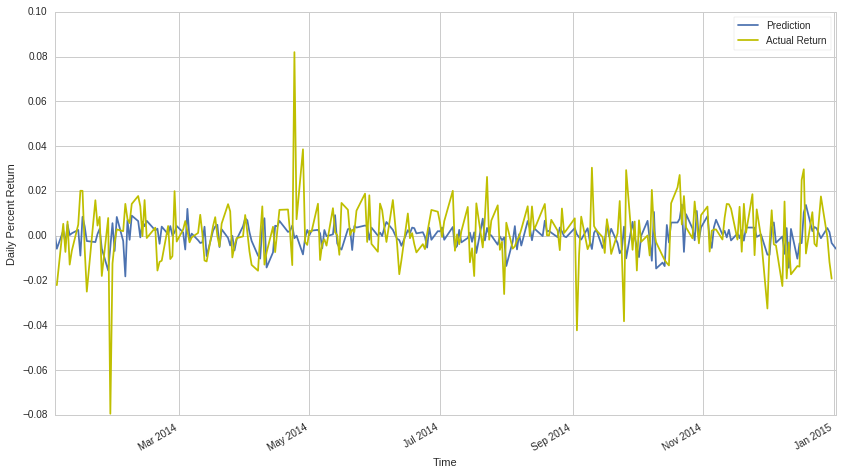

In [73]:
# Use the beta to predict the price of APPLE
[beta_smb, beta_hml, beta_market] = reg_beta[1]
predictions = beta_smb * smb + beta_hml * hml + beta_market * market_return
R = get_pricing('AAPL', fields='price', start_date=start_time, end_date=end_time).pct_change()

predictions.plot()
R.plot(color='Y')
plt.legend(['Prediction', 'Actual Return'])
plt.xlabel('Time')
plt.ylabel('Daily Percent Return');